In [3]:
# Numerical libraries
import numpy as np
import pandas as pd

# Graphical libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Prevent exceptions from crashing the notebook 
import expectexception

# Standardisation tool
from sklearn.preprocessing import StandardScaler

# Data imports
train = pd.read_csv('./data/vowel_train.txt', sep=',', index_col=0)
test = pd.read_csv('./data/vowel_test.txt', sep=',', index_col=0)

### Basic Diagnostics

In [2]:
# Some basic diagnostics

print('Dimensions of training set: ', train.shape)
print('Dimensions of test set: ', test.shape)

missing_train = train.isna().sum().sum()
missing_test = test.isna().sum().sum()

print('Number of missing training values: ', missing_train)
print('Number of missing test values: ', missing_test)

count = set(train['y'].value_counts())
print('Data is perfectly balanced with a count of {} samples per class.'.format(count))

train.head()

Dimensions of training set:  (528, 11)
Dimensions of test set:  (462, 11)
Number of missing training values:  0
Number of missing test values:  0
Data is perfectly balanced with a count of {48} samples per class.


,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
1,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
2,2,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
3,3,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
4,4,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
5,5,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396


Notes: The use of a balanced data set for this exercise is an interesting choice.
Many relevant problems in healthcare seem to be about detecting anomalies that lie in a relatively small subset of cases. These extremely skewed class distributions typically present a problem for standard machine learning approaches. 

Common techniques for addressing imbalanced data would include: 
 - undersampling the majority case, which introduces the issue of discarding useful data
 - oversampling the minority case, which increases the probability of overfitting the classification algorithm 
 - selecting from a class of methods known as "synthetic minority oversampling" (SMOTE), which approximates synthetic data from the minority class by using variants of the k-Nearest Neighbors algorithm; but which also, in turn, runs the risk of massively increasing noise in our data set if the classes of interest are not well-separated in feature space

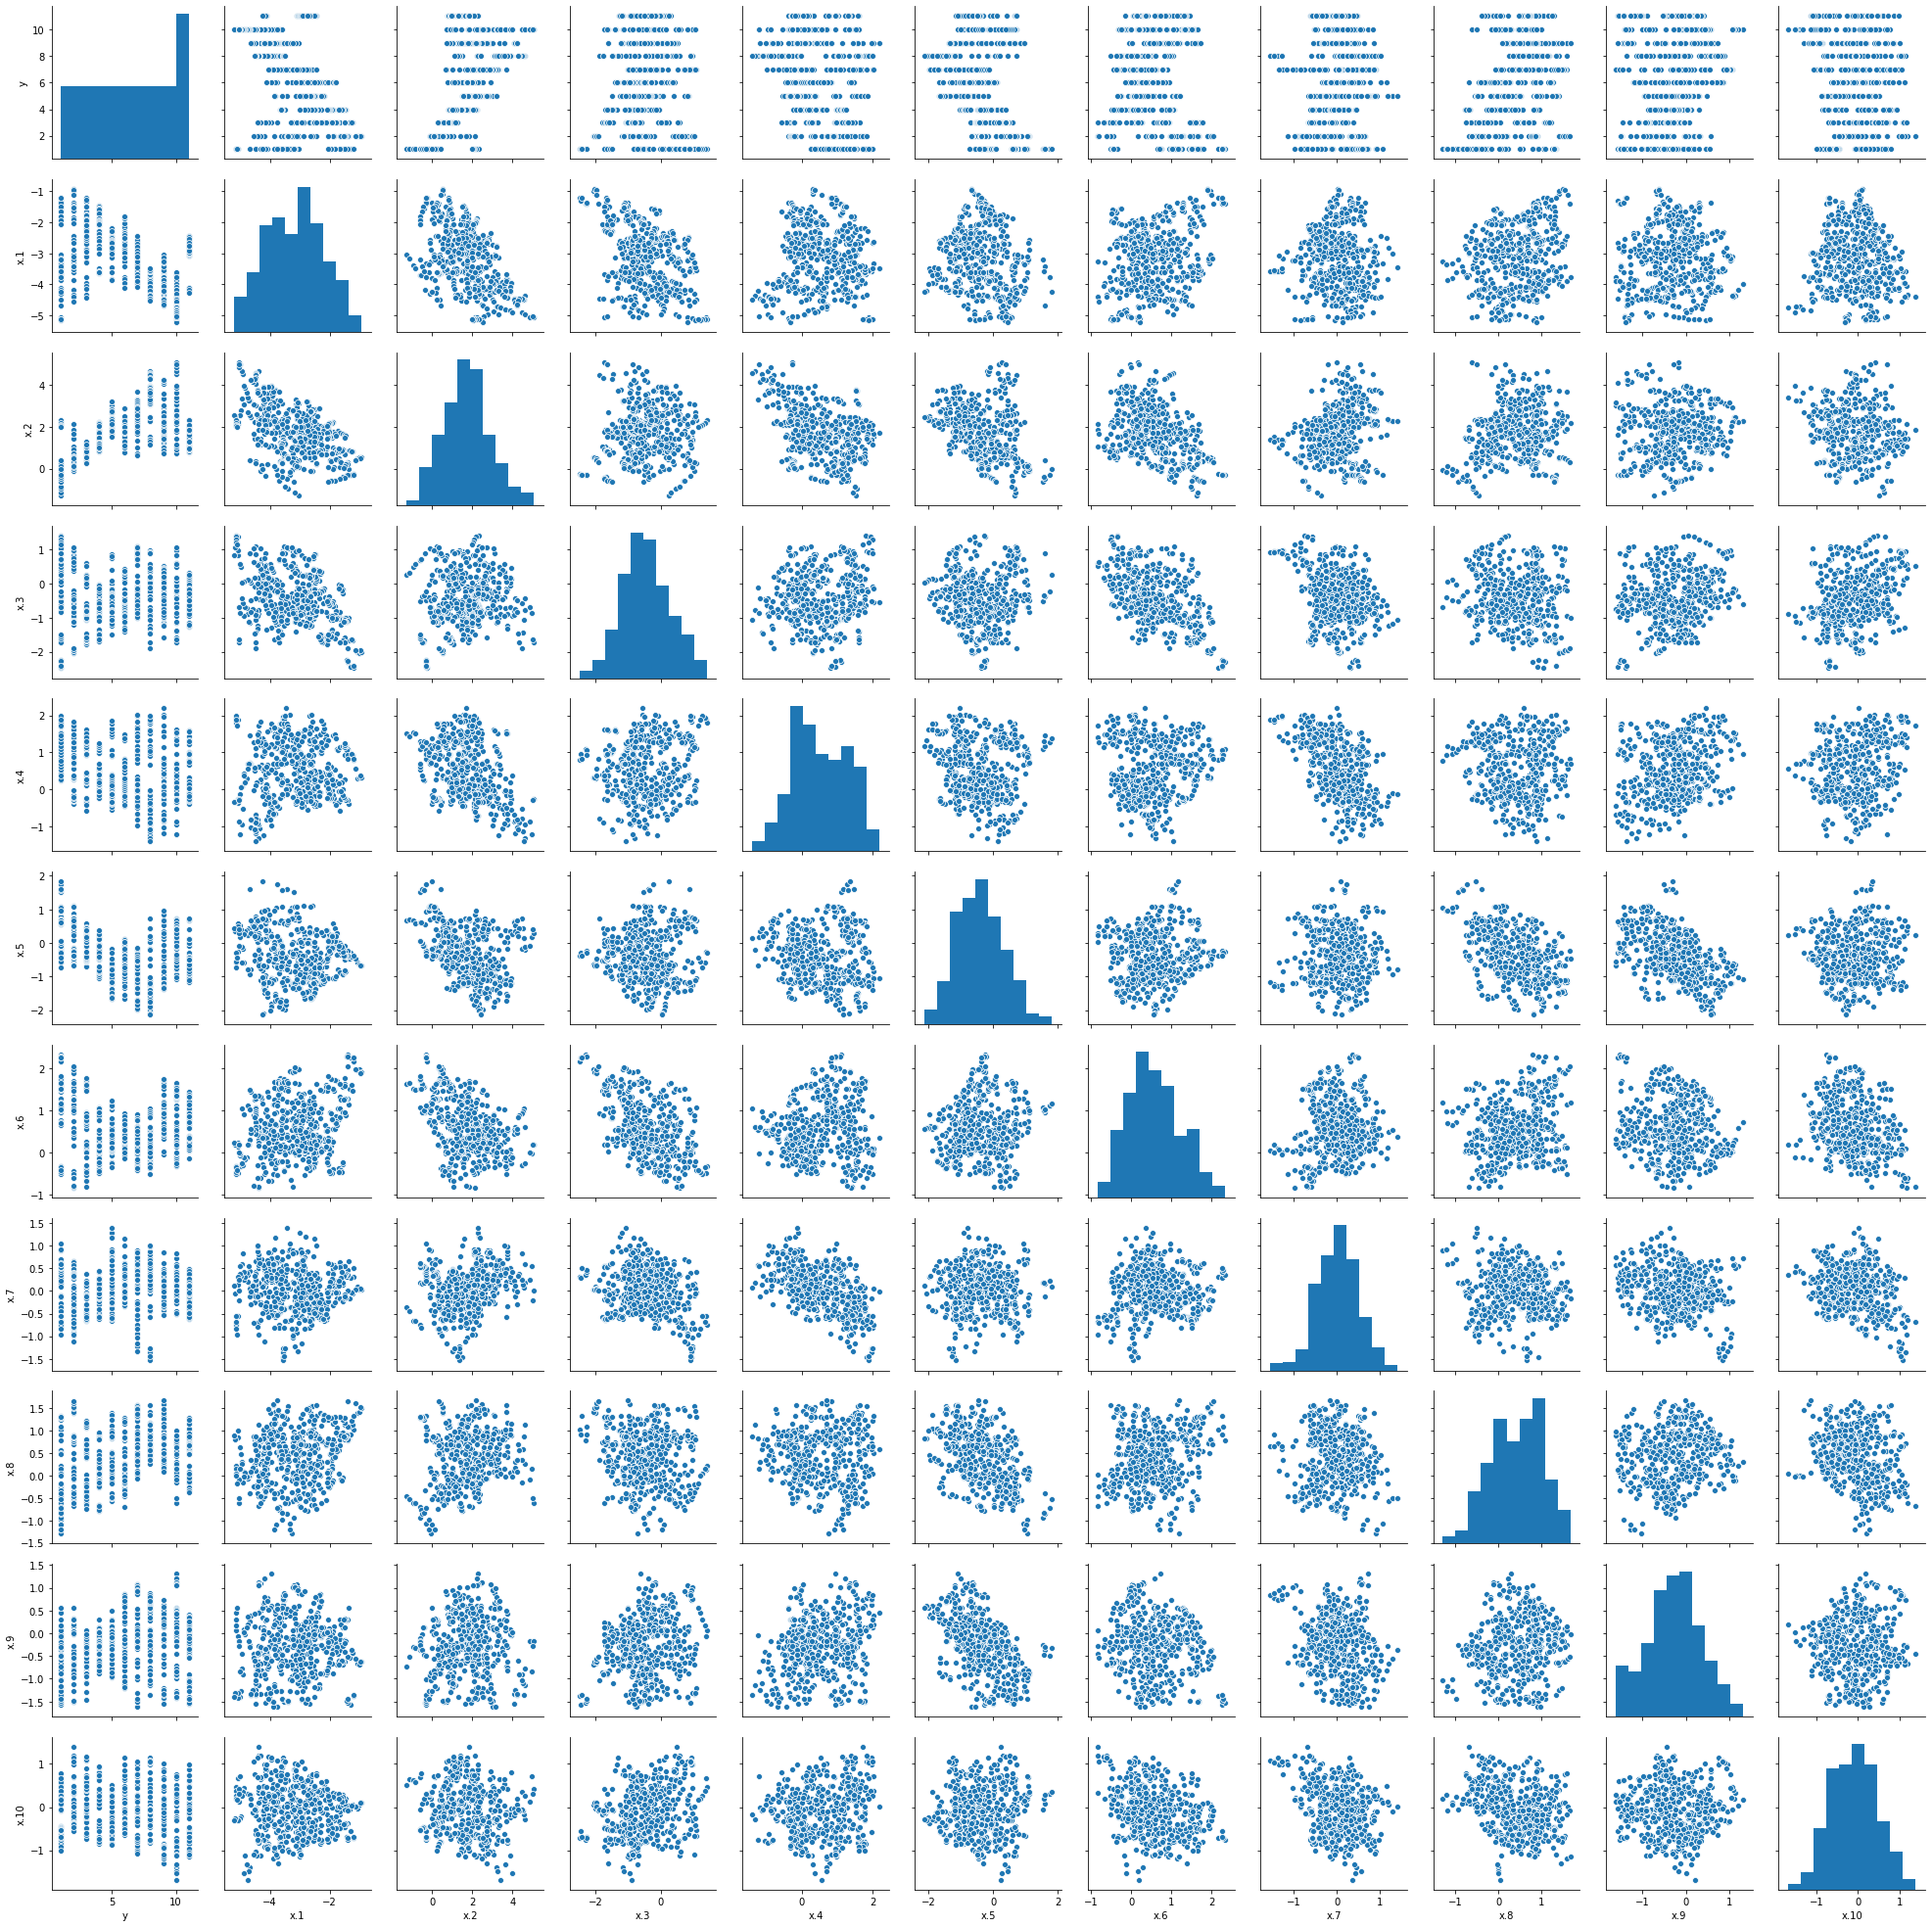

In [155]:
# Obligatory look at the raw data mapped across pairwise relationships in the dataset

sns.pairplot(train)

### Pre-processing

In [4]:
# Prudent to standardise all our data, especially where stochastic gradient descent (SGD) will be involved.
# Data with dimensions on vastly different scales of measurement leads to oscillations in SGD that will 
# slow speed of convergence towards a minimum, especially on large data sets. 

std = StandardScaler()                        # creating an instance of scikit-learn's StandardScaler object

y_train = train['y']                          # setting up training target
dropped = train.copy().drop('y', axis=1)      # setting up training data by dropping the target
x_train = std.fit_transform(dropped)          # fits the gaussian distribution by calculating the
                                                  # mean and variance of each dimension, then transforms
                                                  # the data by applying that fit

y_test = test['y']                            # setting up test target 
dropped = test.copy().drop('y', axis=1)       # setting up test data by dropping the target
x_test = std.transform(dropped)               # transforms the test data using means and variances
                                                  # calculated from the earlier fitting

In [94]:
# Helper functions

# A simple function to calculate error from the given accuracy of classification.
def error(score):
    return round(1 - score, 5)    # round to five figures

# A function to graph the feature importances recorded by tree algorithms.
def graph_importances(best_estimator):
    feature_importance = list(zip(train.columns[1:],                       # assigns the names of features to
                                  best_estimator.feature_importances_))        # their importance from the best
                                                                               # estimator of any given tree model
        
    dtype = [('feature', 'S10'), ('importance', 'float')]                  # corresponds variable with data type
    feature_importance = np.array(feature_importance, dtype=dtype)         # creates an array of mixed data types
    feature_sort = np.sort(feature_importance, order='importance')[::-1]   # sorts array in declining order
    features, score = zip(*list(feature_sort))                             # unpacks the sorted array into 
                                                                               # x and y-columns
    
    return pd.DataFrame({'features':features,                              # plots a dataframe of the given columns
                         'score':score}).plot.bar(x='features',                # as a bar chart
                                                  y='score', 
                                                  color=list('gbkrymc'))


### Modeling

As this assignment asks for comparison against the models listed, we select several models [LDA, QDA] from the list for proof of reproducibility and as a preliminary demonstration of the modeling workflow.

#### Discriminant Analysis

Key assumption in LDA is uniform covariances across classes of Gaussian distribution, the specifics of which are to be fitted upon the data.

In [21]:
from sklearn import discriminant_analysis                              # import necessary libraries

LDA = discriminant_analysis.LinearDiscriminantAnalysis()               # instantiate the LDA object
LDA.fit(x_train, y_train)                                              # fit the model on the training data
LDA_training_error = error(LDA.score(x_train, y_train))                # calculate training error

LDA.predict(x_test)                                                    # apply the fitted model to the test data
LDA_testing_error = error(LDA.score(x_test, y_test))                   # calculate testing error

print('LDA training error: {}'.format(LDA_training_error))
print('LDA testing error: {}'.format(LDA_testing_error))

LDA training error: 0.31629
LDA testing error: 0.55628


Key assumption in QDA is differing covariances across classes of Gaussian distribution, the specifics of which are to be fitted upon the data.

In [20]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()            # from the shared library for discriminant
                                                                           # analysis, instantiate the QDA object
QDA.fit(x_train, y_train)                                              # all steps below as detailed previously
QDA_training_error = error(QDA.score(x_train, y_train))

QDA.predict(x_test)
QDA_testing_error = error(QDA.score(x_test, y_test))

print('QDA training error: {}'.format(QDA_training_error))
print('QDA testing error: {}'.format(QDA_testing_error))

QDA training error: 0.01136
QDA testing error: 0.52814


The results for LDA, QDA conform to the results listed. Reproduction successful!

We begin exploring new methods below.

#### Naive Bayes

Naive Bayes makes the crucial assumption that predictors are conditionally independent within each class; a _naive_ assumption that separates it from discriminant analysis, but also enables it to handle data at scale given the decreased computational workload in sparse covariance estimation. The trade-off, of course, is its inability to capture the more complex relations that may exist between features.

Naive Bayes, like its predecessors in discriminant analysis, assumes that each feature follows a Gaussian distribution.

In [139]:
from sklearn import naive_bayes
gnb = naive_bayes.GaussianNB()                                   # instantiate the Gaussian NB object
gnb.fit(x_train, y_train)                                        # all steps below as detailed in previous workflows
GNB_training_error = error(gnb.score(x_train, y_train))

gnb.predict(x_test)
GNB_testing_error = error(gnb.score(x_test, y_test))

print('GNB training error: {}'.format(GNB_training_error))
print('GNB testing error: {}'.format(GNB_testing_error))

GNB training error: 0.2803
GNB testing error: 0.53896


The test error submitted by Naive Bayes suggests that a model does not, indeed, need to capture highly complex relations in the vowel features in order to compete with LDA or QDA, which have no such restriction. It manages to place ahead of LDA and slightly behind QDA. Meanwhile its training error suggests GNB's decision boundaries are closer to LDA's linear boundaries than QDA's quadratic ones in their efficacy segmenting the training data.

#### Classification and Regression Decision Tree

We employ a class of algorithms that recursively partitions the predictor space into localised segments on which simple, local models can then be fitted. These tree structures sift through samples present at each node in order to determine the variable on which a binary split would generate the purest node (calculated by the Gini index) or the most information gain (cross-entropy — the extent to which uncertainty about the target decreases with a split subspace).

In [121]:
# We begin by examining the results of a default CART on the vowel data.
# Default split is determined by gini indexing.

from sklearn import tree

CART = tree.DecisionTreeClassifier()    # create an instance of the Decision Tree classifier object
                                        # all subsequent steps are as detailed in previous workflows
CART.fit(x_train, y_train)
CART_training_error = error(CART.score(x_train, y_train))

CART.predict(x_test)
CART_testing_error = error(CART.score(x_test, y_test))

print('CART training error: {}'.format(CART_training_error))
print('CART testing error: {}'.format(CART_testing_error))

CART training error: 0.0
CART testing error: 0.55411


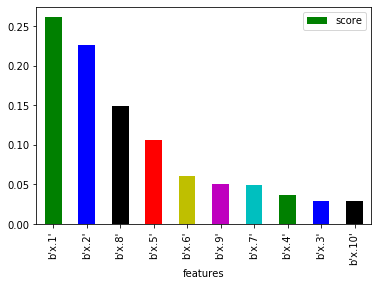

In [114]:
# Feature importances track the total percentage drop in gini index (or cross-entropy) per variable.

graph_importances(CART)

A primary issue with the default CART is extreme overfitting, as the tree is free to pursue pure nodes at unlimited depth. A solution is to introduce cost-complexity pruning, which iteratively trims down the subtrees of an overfit tree based off performance in cross-validation.

Scikit-learn does not implement cost-complexity pruning, however. We instead pursue hyperparameter optimisation via cross-validation: partition our training data into K folds and take K turns cycling through one fold for cross-validating our model while fitting the model on K - 1 folds. Results are then averaged.

A small data set such as the one in this exercise is bound to suffer from high bias as well as high variance under K-fold cross validation. This data set should therefore benefit from taking the logic of cross-validation to the extreme, in the form of Leave-One-Out Cross-Validation. With 48 samples per class, we partition into 48 parts, leaving only one observation out for cross-validating. LOOCV possesses high variance, since each cross-validation shares 46 common sets of observations with every other cycle; but should more than make up for it as an unbiased estimate of the generalisation error.

Cross-validation is a useful method for many purposes, not least a manual pruning of the overfitted CART by controlling for:
 - maximum allowed depth of tree growth
 - minimum number of samples required at each internal node to continue splitting
 - minimum number of samples required for a node to become a leaf

In [122]:
# We import two implementations of cross-validation: grid search and randomised search.
# Grid search exhaustively searches over the entire parameter space while randomised
# search searches a randomised sample of the parameter space — the latter can be 
# just as effective with much less time needed.

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

params = {#'max_depth': np.arange(1, 32),            # a first hyperparameter pass over ONLY max_depth space
            'max_depth': [15],                           # finds 15 to be the best tree depth
            'min_samples_split': np.arange(2, 5),
            'min_samples_leaf': np.arange(1, 5),
            #'random_state': [42]                     # sets a random seed — useful for consistency
         }                                               # when tuning a model

cart_cv = GridSearchCV(estimator=CART,               # creates a GridSearchCV object with loaded parameters
                      param_grid=params,
                      cv=48,                         # specification of LOOCV
                      verbose=0,                     # controls text alerts during runtime
                      n_jobs=-1)                     # unleashes the total hardware power of all computing cores

cart_cv.fit(x_train, y_train)                        # fits the cross-validation model to the training data

cart_training_error = error(cart_cv.best_score_)     # computes the lowest error from the best estimator

print('CART training error: {}'.format(cart_training_error))    
print('The best parameters found: ', cart_cv.best_params_)

y_pred = cart_cv.predict(x_test)                              # generates predictions on test data 
                                                                  # using the best estimator
cart_testing_error = error(accuracy_score(y_test, y_pred))    # computes test error of our best estimator

print('CART testing error: {}'.format(cart_testing_error))

CART training error: 0.16098
The best parameters found:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
CART testing error: 0.54113


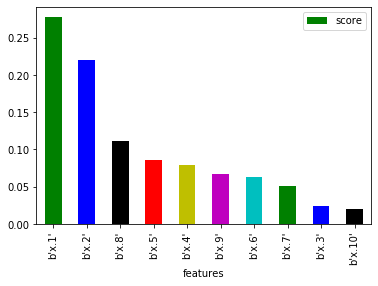

In [96]:
graph_importances(cart_cv.best_estimator_)

We appear to improve our test error by 0.013, although it is probably well within the variance afforded by either model. The substantial rise in training error for our comparatively pruned tree demonstrates considerably _less_ overfitting than our default CART.

Both models agree on the absolute ranking of x1 and x2, although x8 takes a hit of a couple percentage points in its value to the pruned model. 

#### Random Forest Classifier

Decision trees are inherently weak learners with both high bias and high variance. The random forest has two parts to address this. 

First, it is a parallel ensembling of many weak learners via bootstrap aggregation, where data points are resampled with replacement to create many noisy trees that then, in classification, take a majority vote of the predicted class. 'The wisdom of crowds' averages out the variance in each individual.

Second, it randomly subselects features for each tree in order to decorrelate and debias the trees in the forest. 

The relevant hyperparameters to tune, in order of importance, are:
 - number of trees for each forest
 - maximum number of subselected features, which we conventionally set to the default square root of total number of features
 - maximum allowed depth of tree growth

In [78]:
# For the random forest, we optimise hyperparameters in two stages.
# First, we conduct a large-scale search over large intervals (entire magnitudes)
# using randomised search over a 10-fold cross-validation for speed of computation.
# During this stage, we isolate our search hyperparameter by hyperparameter, 
# in order of importance.
#
# Second, we apply an exhaustive grid search over best-validated hyperparameter
# ranges and values in a LOOCV to fit the final model.

from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()     # instantiate a Random Forest classifier object

####################### Step 1: Large-scale Hyperparameter Tuning
"""
params = {#'n_estimators': [int(x) for x in np.linspace(5, 1000, 10)],  # best n_estimate found = 778
                                                                        # search range [650, 890] next
    
          'n_estimators': [int(x) for x in np.linspace(650, 890, 5)],   # best n_estimate found = 770
                                                                        # search range [710, 830] next
          'max_features': ['auto'], 
          'max_depth': np.arange(1, 32),                                # best depth found = 14
          'random_state': [42]
         }

rfc_cv = RandomizedSearchCV(estimator=RFC,                              # key parameters to set are
                            param_distributions=params,                     # cv = number of folds and
                            cv=10, verbose=1, n_jobs=-1, n_iter=50)         # n_iter = number of samples 
                                                                            # in parameter space
"""
####################### Step 2: Granular Hyperparameter Tuning

params = {#'n_estimators': [int(x) for x in np.linspace(710, 830, 13)],  # best n_estimate found = 740
          'n_estimators': [740],                                         # Random Forest code from here on down
          'max_features': ['auto'],                                          # is structured identically as in
          'max_depth': [14]                                                  # previous workflows
         }

rfc_cv = GridSearchCV(estimator=RFC,
                      param_grid=params,
                      cv=48, verbose=1, n_jobs=-1)


####################### Shared code below runs model fitting

rfc_cv.fit(x_train, y_train)

rfc_training_error = error(rfc_cv.best_score_)

print('RFC training error: {}'.format(rfc_training_error))
print('The best parameters found: ', rfc_cv.best_params_)

Fitting 48 folds for each of 13 candidates, totalling 624 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 624 out of 624 | elapsed:  8.9min finished


RFC training error: 0.02652
The best parameters found:  {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 740, 'random_state': 42}


In [80]:
y_pred = rfc_cv.predict(x_test)
rfc_testing_error = error(accuracy_score(y_test, y_pred))

print('RFC testing error: {}'.format(rfc_testing_error))

RFC testing error: 0.4026


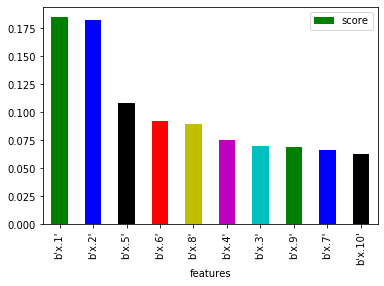

In [90]:
graph_importances(rfc_cv.best_estimator_)

With a training error of 0.027 and a test error of 0.403, our random forest predicts the best among all our models thus far. 

In a twist, our feature importance graph significantly diminishes the importance of x1 and x2 by a total of ~13% — 8% from x1 and 5% from x2 — a loss that is fairly evenly redistributed outside the top three variables. Notably x5 is the third most important feature in stead of x8, which was third in the last two trees.

#### eXtreme Gradient Boosted Decision Tree Classifier

The boosted decision tree takes an approach orthogonal to that of the random forest by creating an ensemble of *sequential* trees, fitting subsequent subtrees on the updated residual of the total tree preceding. The boosted tree proceeds to slowly learn the data, focusing on the residual weaknesses, instead of overfitting at once.

The relevant hyperparameters to tune are:
 - number of subtrees for each boosted tree
 - the maximum depth of each boosted tree
 - the learning rate of the tree
 - gamma, the minimum loss required in order to split a node
 
Of incidental importance is the optimisation method, stochastic gradient descent, by which each successive subtree is fitted.

Stochastic gradient boosting builds on the core GBDT structure above by subsampling samples, and also features, in the formation of each tree, for much the same reason as in the random forest: to reduce bias. 

XGBoost builds further atop that by adding lasso and ridge penalisation terms to control overfitting, as well as a fast interpolative implementation of node-splitting inspired by Microsoft's LightGBM.

In [137]:
# Tuning XGBoost with its ranks of hyperparameters would have gone considerably faster
# with an implementation of Bayesian Optimisation in place of grid or randomised search.
# A note for future installation.

from xgboost import XGBClassifier

xgb = XGBClassifier()    # instantiate an XGBClassifier object

####################### Step 1: Large-scale Hyperparameter Tuning
"""
params = {#'n_estimators': [int(x) for x in np.linspace(50, 1000, 10)]       # best n_estimator found = 577
                                                                             # search range [480, 680] next
          #'n_estimators': [int(x) for x in np.linspace(480, 680, 11)]       # best n_estimator found = 540
                                                                             # range is [520, 560]
          #'max_depth': np.arange(3, 32)                                     # best depth found = 7
          #'learning_rate': np.linspace(0.1, 0.01, 10)                       # best learning_rate found = 0.06
          #'subsample': np.linspace(0.8, 1, 11)                              # best subsample = 0.9
          #'colsample_bytree': np.linspace(0.8, 1, 11)                       # best colsample_bytree = 0.95
          #'gamma': np.linspace(1, 7, 7)                                     # best gamma = 1
          #'reg_alpha':[0.001, 0.01, 0.1, 1, 100]                            # best reg_alpha = 0.01
          #'reg_alpha': np.linspace(.05, .1, 11)                             # best reg_alpha = 0.06
          #'reg_lambda':[0.001, 0.01, 0.1, 1, 100]                           # best reg_alpha = 0.01
          #'reg_lambda': np.linspace(.05, .1, 11)                            # best reg_alpha = 0.065
          'random_state': [42]
         }

xgb_cv = RandomizedSearchCV(estimator=xgb,
                            param_distributions=params,
                            cv=10, verbose=1, n_jobs=-1, n_iter=20)
"""
####################### Step 2: Granular Hyperparameter Tuning

params = {'n_estimators': [int(x) for x in np.linspace(520, 560, 5)],        # XGBoost code from here on down
          'max_depth': [7],                                                      # is structured identically as in
          'learning_rate': [0.06],                                               # previous workflows
          'subsample': [0.9],
          'colsample_bytree': [0.95],
          'gamma': [1],
          'reg_alpha': [0.06],
          'reg_lambda': [0.065]}

xgb_cv = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=48, verbose=1, n_jobs=-1)


####################### Shared code below runs model fitting

xgb_cv.fit(x_train, y_train)

xgb_training_error = error(xgb_cv.best_score_)

print('XGB training error: {}'.format(xgb_training_error))
print('The best parameters found: ', xgb_cv.best_params_)

Fitting 48 folds for each of 5 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.9min finished


XGB training error: 0.0947
The best parameters found:  {'colsample_bytree': 0.95, 'gamma': 1, 'learning_rate': 0.06, 'max_depth': 7, 'n_estimators': 520, 'reg_alpha': 0.06, 'reg_lambda': 0.065, 'subsample': 0.9}


In [138]:
y_pred = xgb_cv.predict(x_test)
xgb_testing_error = error(accuracy_score(y_test, y_pred))

print('XGB testing error: {}'.format(xgb_testing_error))

XGB testing error: 0.48918


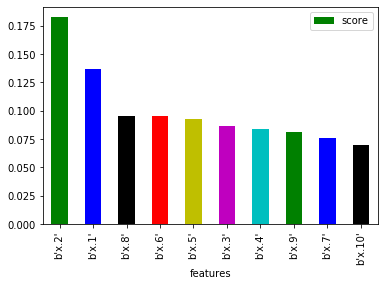

In [91]:
graph_importances(xgb_cv.best_estimator_)

Notably, in this feature importance graph, x1 and x2 switch placements compared to where they were in all our previous trees.

### Conclusion

We chose mostly to focus on a class of algorithms that tends to be computationally heavy but, with modern hardware, is finding increasing use in industry — decision trees. The strength of trees lies in their flexibility to map regions of varying size in input space where target responses are similar. This is a marked departure from kNN, which defines similarity only in input space and not in the target response; and which is also slaved to a constant _k_ value. 

Trees are interpretable structures, unlike many nonparametric methods that attempt to fit local spaces. One can, after all, call a tree object to examine the hierarchy of its node-splits. Typical downsides of trees, however, are a tendency to overfit.

This is exacerbated by the size of the data, with barely 500 observations each to training and testing. Conventional wisdom would dictate that simplest algorithms work best. Unrestrained complexity cannot help but overfit, and indeed, all of the algorithms that we've run, and seen from ESLII, do overfit significantly on the training data; trees among the worst of them.

The least complex trees we ran suffered from a basic structural inadequacy, as neither CART nor its optimised sibling saw great improvement over the baseline LDA/QDA results from ESLII. XGBoost, as the most complex model we tuned, was significantly improved by 0.052 points to dip beneath 0.50 accuracy, a rare achievement. Random Forest, with its focus on improving both bias and variance yet relatively few hyperparameters to tweak, was structurally a happy medium between CART and XGBoost, with the best accuracy of 0.403 to date.

Models of further comparative interest would include SVMs using various kernels — it remains to be seen if the vowels can be well-separated by specific functional forms of hyperplane (if QDA's overfit is any indication, a quadratic hyperplane should be a first try). Certainly SVMs are appropriate for such a small data set, although computationally intractable for work at scale, beyond a few hundred thousand observations. Whereas building a convolutional net with a softmax output makes for a fun classifier — at scale. For this amount of data, a convolutional net would be overkill and underperform accordingly, relative to the random forest but on par, perhaps, with the XGBoost.